# 자연어와 단어의 분산 표현

## 통계 기반 기법

### 말뭉치 전처리

#### 단어에 ID 부여하기

In [7]:
text = "You say goodbye and I say hello."
text = text.lower()
text = text.replace('.', ' .')
words = text.split()

word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [10]:
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

#### 동시발생 행렬 구현하기

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [14]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2)) + eps
    ny = y / np.sqrt(np.sum(y**2)) + eps

    return np.dot(nx, ny)

In [15]:
## you와 i의 유사도 구하기

vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

# you 단어의 벡터
c0 = C[word_to_id['you']]
# i 단어의 벡터
c1 = C[word_to_id['i']]

print(cos_similarity(c0, c1))

0.7071068053286839


In [16]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어를 꺼낸다
    if query not in word_to_id:
        print('{0}(을)를 찾을 수 없습니다.'.format(query))
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 유사도 기준으로 내림차순 출력
    cnt = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        cnt += 1
        if cnt >= top:
            return

In [17]:
text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word2id, id2word, C, top=5)


[query] you
 goodbye: 0.7071068053286839
 i: 0.7071068053286839
 hello: 0.7071068053286838
 say: 3.00000007e-08
 and: 2.4142136323730952e-08


## PMI 구현

In [18]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))

    return M

In [20]:
W = ppmi(C)

# 유효 자리 숫자 3자리까지
np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


## SVD를 차원 감소 시키기

In [24]:
U, S, V = np.linalg.svd(W)              # linalg는 linear algebra 선형대수의 약자

print(C[0])
print(W[0])
print(U[0])
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -1.205e-01 -3.886e-16  0.000e+00 -9.323e-01
 -2.087e-17]
[-1.110e-16  3.409e-01]


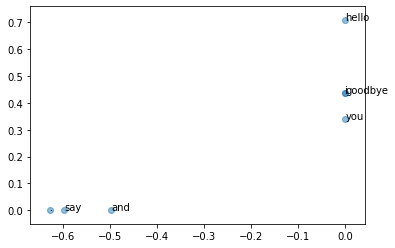

In [25]:
import matplotlib.pyplot as plt

for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

## Penn TreeBank 데이터셋 불러오기

In [26]:
from dataset import ptb

corpus, word2id, id2word = ptb.load_data('train')

print('말뭉치 크기')
print('corpus[:30]: ', corpus[:30])
print()
print('id2word[0]: ', id2word[0])
print('id2word[1]: ', id2word[1])
print('id2word[2]: ', id2word[2])
print()
print('word2id[\'car\']: ', word2id['car'])
print('word2id[\'happy\']: ', word2id['happy'])
print('word2id[\'lexus\']: ', word2id['lexus'])


Done
말뭉치 크기
corpus[:30]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id2word[0]:  aer
id2word[1]:  banknote
id2word[2]:  berlitz

word2id['car']:  3856
word2id['happy']:  4428
word2id['lexus']:  7426


## PTB 데이터셋 평가

In [27]:
window_size = 2
wordvec_size = 100

vocab_size = len(word2id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('SVD 계산 ...')
try:
    # SVD 빠른 버전
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word2id, id2word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...

[query] you
 i: 0.6922403573989868
 we: 0.5796071290969849
 do: 0.5604